## xcube Data Store Framework - Getting Started

This notebook provides a walk-through demonstrating how to use the _xcube data store framework_.

The xcube Data Store Framework provides a uniform way 
* to retrieve data using popular Python in-memory data models (e.g. xarray.Dataset, geopandas.GeoDataFrame);
* to decode/encode data from different data formats (Zarr, NetCDF, GeoJSON, Shapefiles);
* to access data from different sources (local directory, AWS S3 buckets, API-based data services).

Data stores can be used to search data, open data, write data. These operations are generic and can have store-specific parameters.
xcube uses JSON Schema to describe store-specific parameters for store initialisation, search data, open data, and write data operations.

xcube provides three data store implementations by default:
* `file` - maintains data in a local filesystem directory;
* `s3` - maintains data in object storage compatible to AWS S3.
* `memory` - holds data in-memory, very useful for testing;

New data store implementations can be added to xcube, usually through xcube plugins. 
Four data stores based on different data APIs are available in the [xcube GitHub organisation](https://github.com/dcs4cop):
* `sentinelhub` - Datasets from Sentinel Hub by [plugin xcube_sh](https://github.com/dcs4cop/xcube-sh) with a dedicated [Notebook](./2_sentinel_hub.ipynb)
* `cciodp` and `ccizarr` - Datasets from ESA Climate Change Initiative (CCI) by [plugin xcube_cci](https://github.com/dcs4cop/xcube-cci) with a dedicated [Notebook](./3_esa_climate_change_initiative.ipynb)
* `cds` - Datasets from the C3S Climate Data Store by [plugin xcube_cds](https://github.com/dcs4cop/xcube-cds) with a dedicated [Notebook](./4_c3s_climate_data_store.ipynb)
* `cmems` - Datasets from Copernicus Marine Service by [plugin xcube_cmems](https://github.com/dcs4cop/xcube-cmems) with a dedicated [Notebook](./7_cmems_data_store.ipynb)

If you are interested in the development of new data stores for xcube, you may want to follow the [xcube data store conventions](https://github.com/dcs4cop/xcube/blob/master/docs/source/storeconv.md).

This notebook provides an introduction to the xcube data store framework by presenting some of its hight-level entry-point functions. The data store functions and methods work in the same way for all types of data stores. Only the store initialisation, open, write, and search parameters are store-specific.

In [1]:
# mandatory xcube store imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization. 
# JSON provides pretty-printing of Python lists and dictionaries.
from IPython.display import JSON

### Querying available data stores and instantiating a store

We start by having a look at the available data stores. This is done by calling function `find_data_store_extensions()`.

In [2]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

The default data stores `memory`, `file` and `s3` are filesystem-based, writable data stores and always present. Other data stores may be appear depending on which xcube plugins have been installed.

To access the actual data, we need data store _instances_. They can be obtained by the top-level function `new_data_store(store_id, **store_params)`. It receives `store_id`, the data store's identifier, e.g. `file`, and one or more store-specific parameters. Another function `get_data_store_params_schema(store_id)` provides a description of the store-specific parameters (as JSON Schema).

For example, which parameters are accepted by `new_data_store()` when using the `s3` data store?

In [3]:
get_data_store_params_schema('s3')

The field `properties` lists the available data store parameters. For the filesystem-based data stores `file`, `s3`, and `memory` the most important parameter is `root` which specifies the data store's root path into the filesystem. 

For the filesystem-based data stores there is also a special parameter `storage_options` that can contain further filesystem-specific parameters. 

Here are some examples how to parameterize an `s3` data store that can access AWS S3 compatible object storage:

Public bucket on AWS S3: 
```python
store = new_data_store('s3', root="<bucket_name>", storage_options=dict(anon=True))
```
Private bucket on AWS S3: 
```python
store = new_data_store('s3', root="<bucket_name>", storage_options=dict(anon=False, key="<AWS_ACCESS_KEY_ID>", secret="<AWS_SECRET_ACCESS_KEY>"))
```
Public object storage other than AWS S3: 
```python
store = new_data_store('s3', root="<bucket_name>", storage_options=dict(anon=True, client_kwargs=dict(endpoint_url="<object_storage_api_endpoint_url>")))
```

Which parameters are accepted by `new_data_store()` when using the `file` data store?

In [4]:
get_data_store_params_schema('file')

We try it using xcube serve demo directory: 

In [5]:
store = new_data_store('file', root='../../serve/demo')
store

<xcube.core.store.fs.registry.get_fs_data_store_class.<locals>.FsDataStoreClass at 0x2364884fc70>

### Querying the data contained in a store

The data store method `list_data_ids()` returns a list of the available data resource identifiers. 
Note, if a data store is expected to contain a large number of data resources, you could consider using `get_data_ids()`, which returns a light-weight iterator instead.

Depending on the data store content, the list may contain both gridded and vector datasets. The root directory used above contains three demo datasets:

In [6]:
store.list_data_ids()

['cube-1-250-250.zarr', 'cube-5-100-200.zarr', 'cube.nc']

The `get_data_ids()` method returns iterators instead of lists or tuples. That's why we use the `list` function above to be able to print the results in this notebook.

We can obtain metadata about the data using the `describe_data(data_id)` method. It returns a data descriptor object that represents the data's metadata:

In [7]:
store.describe_data('cube-1-250-250.zarr')

The type specifier value `"dataset[cube]"` tells us that the data resource `"cube-1-250-250.zarr"` will be (A) represented as an `xarray.Dataset` object and (B) uses a [data cube schema](https://github.com/dcs4cop/xcube/blob/master/docs/source/cubespec.md) once it is being accessed. Another possible type specifier is `"geodataframe"` for vector data data. In such case the data would be represented as a `geopandas.GeoDataFrame`.

We can also search in stores. However this feature is **not yet fully implemented** for many data stores, mostly because support for search parameters is missing. What works for most stores is searching without any search parameters:

In [8]:
for data_descriptor in store.search_data():
    display(80 * '-')
    display(data_descriptor)

'--------------------------------------------------------------------------------'

'--------------------------------------------------------------------------------'

'--------------------------------------------------------------------------------'

As search results may be large, also the `search_data()` methods returns iterators instead of lists or tuples. 

### Opening data from a store

The store's `open_data(data_id, **open_params)` method is used to access the data:

In [9]:
dataset = store.open_data('cube-1-250-250.zarr')
dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 5)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_tsm       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    kd489          (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

The result is an `xarray.Dataset` using a data cube schema. This was expected, because the data's type specifier was `"dataset[cube]"`.

The `open_data()` method also accepts store-specific open parameters. We can ask the store which parameters are available. The result is again returned as in JSON schema format:

In [10]:
store.get_open_data_params_schema()

Sometimes open parameters can be even data-specific, therefore we can pass the optional `data_id` keyword-argument:

In [11]:
store.get_open_data_params_schema(data_id='cube-1-250-250.zarr')

From the schema above, we find `drop_variables` is an optional open parameter that can be used to open just a subset of variables. Let's open the same dataset again, this time with less variables:

In [12]:
dataset = store.open_data('cube-1-250-250.zarr', drop_variables=['kd489', 'conc_tsm'])
dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 1000, lon: 2000, time: 5)
Coordinates:
  * lat            (lat) float64 52.5 52.5 52.49 52.49 ... 50.01 50.01 50.0 50.0
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * lon            (lon) float64 0.00125 0.00375 0.00625 ... 4.994 4.996 4.999
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(250, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

Plot 4th time slice of the `conc_chl` data cube:

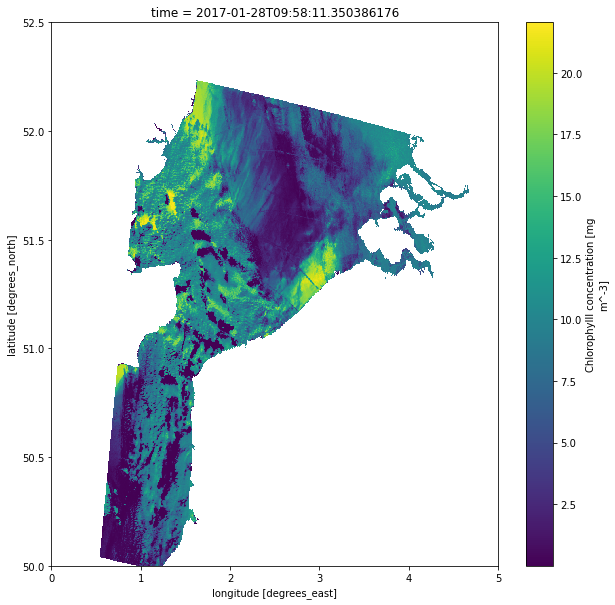

In [13]:
dataset.conc_chl.isel(time=3).plot.imshow(figsize=(10, 10))

### Writing data into a store

Let's create a new dataset as a spatial subset of the first:

In [14]:
new_dataset = dataset.sel(lon=slice(2.8, 4.75), lat=slice(52.1, 51.2))
new_dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 360, lon: 780, time: 5)
Coordinates:
  * lat            (lat) float64 52.1 52.1 52.09 52.09 ... 51.21 51.21 51.2 51.2
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon            (lon) float64 2.801 2.804 2.806 2.809 ... 4.744 4.746 4.749
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(130, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

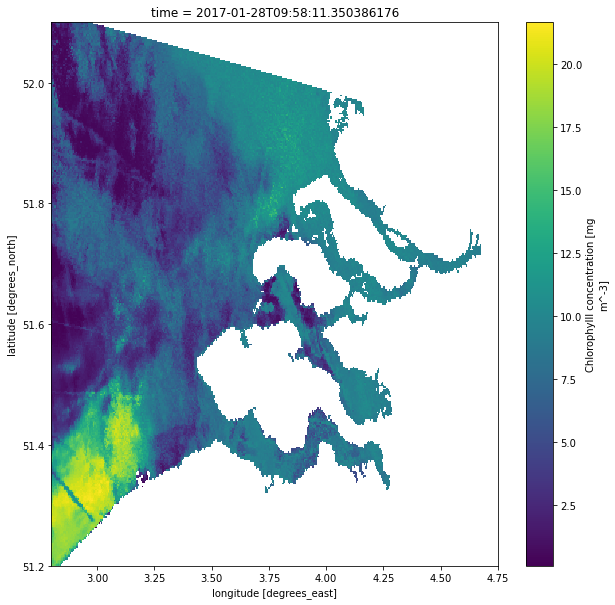

In [15]:
new_dataset.conc_chl.isel(time=3).plot.imshow(figsize=(10, 10))

And let's also drop empty time slices (will drop 2 empty slices):

In [16]:
new_dataset = new_dataset.dropna('time', how='all')
new_dataset

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 360, lon: 780, time: 3)
Coordinates:
  * lat            (lat) float64 52.1 52.1 52.09 52.09 ... 51.21 51.21 51.2 51.2
    lat_bnds       (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
  * lon            (lon) float64 2.801 2.804 2.806 2.809 ... 4.744 4.746 4.749
    lon_bnds       (lon, bnds) float64 dask.array<chunksize=(130, 2), meta=np.ndarray>
  * time           (time) datetime64[ns] 2017-01-16T10:09:21.834255872 ... 20...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    c2rcc_flags    (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    conc_chl       (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
    quality_flags  (time, lat, lon) float64 dask.array<chunksize=(1, 90, 130), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7

We can write data to a store using the store's `write_data(data_id, **write_params)` method. Again, it can take store-specific write parameters:

In [17]:
store.get_write_data_params_schema()

There are no mandatory write parameters, so we can go without any. The format will be Zarr as this is xcube's default for data resources of type `xarray.Dataset`. 

Unfortunately, subsetting the data has changed its internal chunking in way that is incompatible with Zarr. So we need to rechunk the datasets first using xcube's `chunk_dataset` function, so finally all chunks of all variables have equal dimensions.

In [18]:
from xcube.core.chunk import chunk_dataset
new_dataset = chunk_dataset(new_dataset, dict(lat=90, lon=90, time=1), format_name='zarr')

Now we can write without errors. The write method returns the `data_id` of the data just being written:

In [19]:
store.write_data(new_dataset, 'cube-1-250-250-subset.zarr', replace=True)

'cube-1-250-250-subset.zarr'

Make sure it is in the store:

In [20]:
store.list_data_ids()

['cube-1-250-250-subset.zarr',
 'cube-1-250-250.zarr',
 'cube-5-100-200.zarr',
 'cube.nc']

### Deleting data from a store

Deleting data works as expected:

In [21]:
store.delete_data('cube-1-250-250-subset.zarr')

In [22]:
store.list_data_ids()

<IPython.core.display.JSON object>